# Palantir pseudotime

## Library imports

In [1]:
import os
import sys

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import palantir
import scanpy as sc
import scvelo as scv

sys.path.extend(["../../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
Global seed set to 0


## General settings

In [2]:
sc.settings.verbosity = 2
scv.settings.verbosity = 3

In [3]:
mpl.use("module://matplotlib_inline.backend_inline")
mpl.rcParams["backend"]

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial"]

In [4]:
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map="viridis")

In [5]:
SAVE_FIGURES = False
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / "cytotrace_kernel" / "embryoid_body", exist_ok=True)

## Data loading

In [6]:
adata = sc.read(DATA_DIR / "embryoid_body" / "embryoid_body.h5ad")
adata

AnnData object with n_obs × n_vars = 31029 × 19122
    obs: 'stage', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

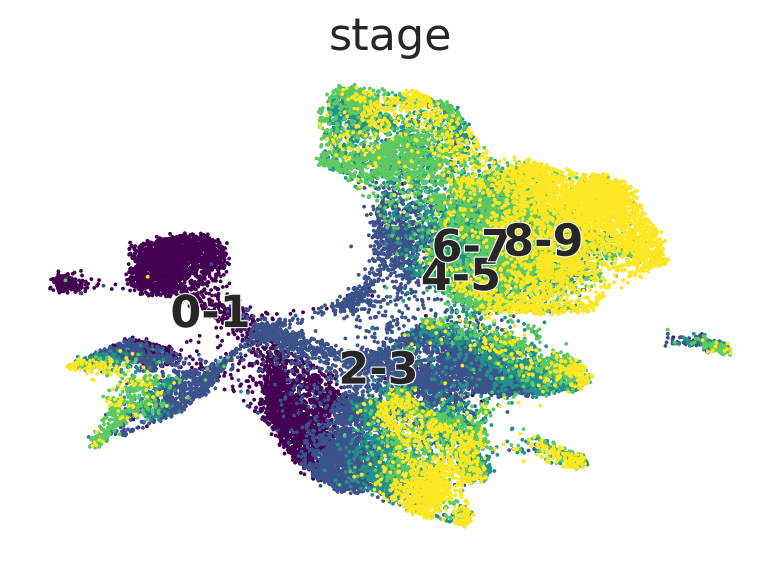

In [7]:
scv.pl.scatter(adata, basis="umap", c="stage", palette="viridis")

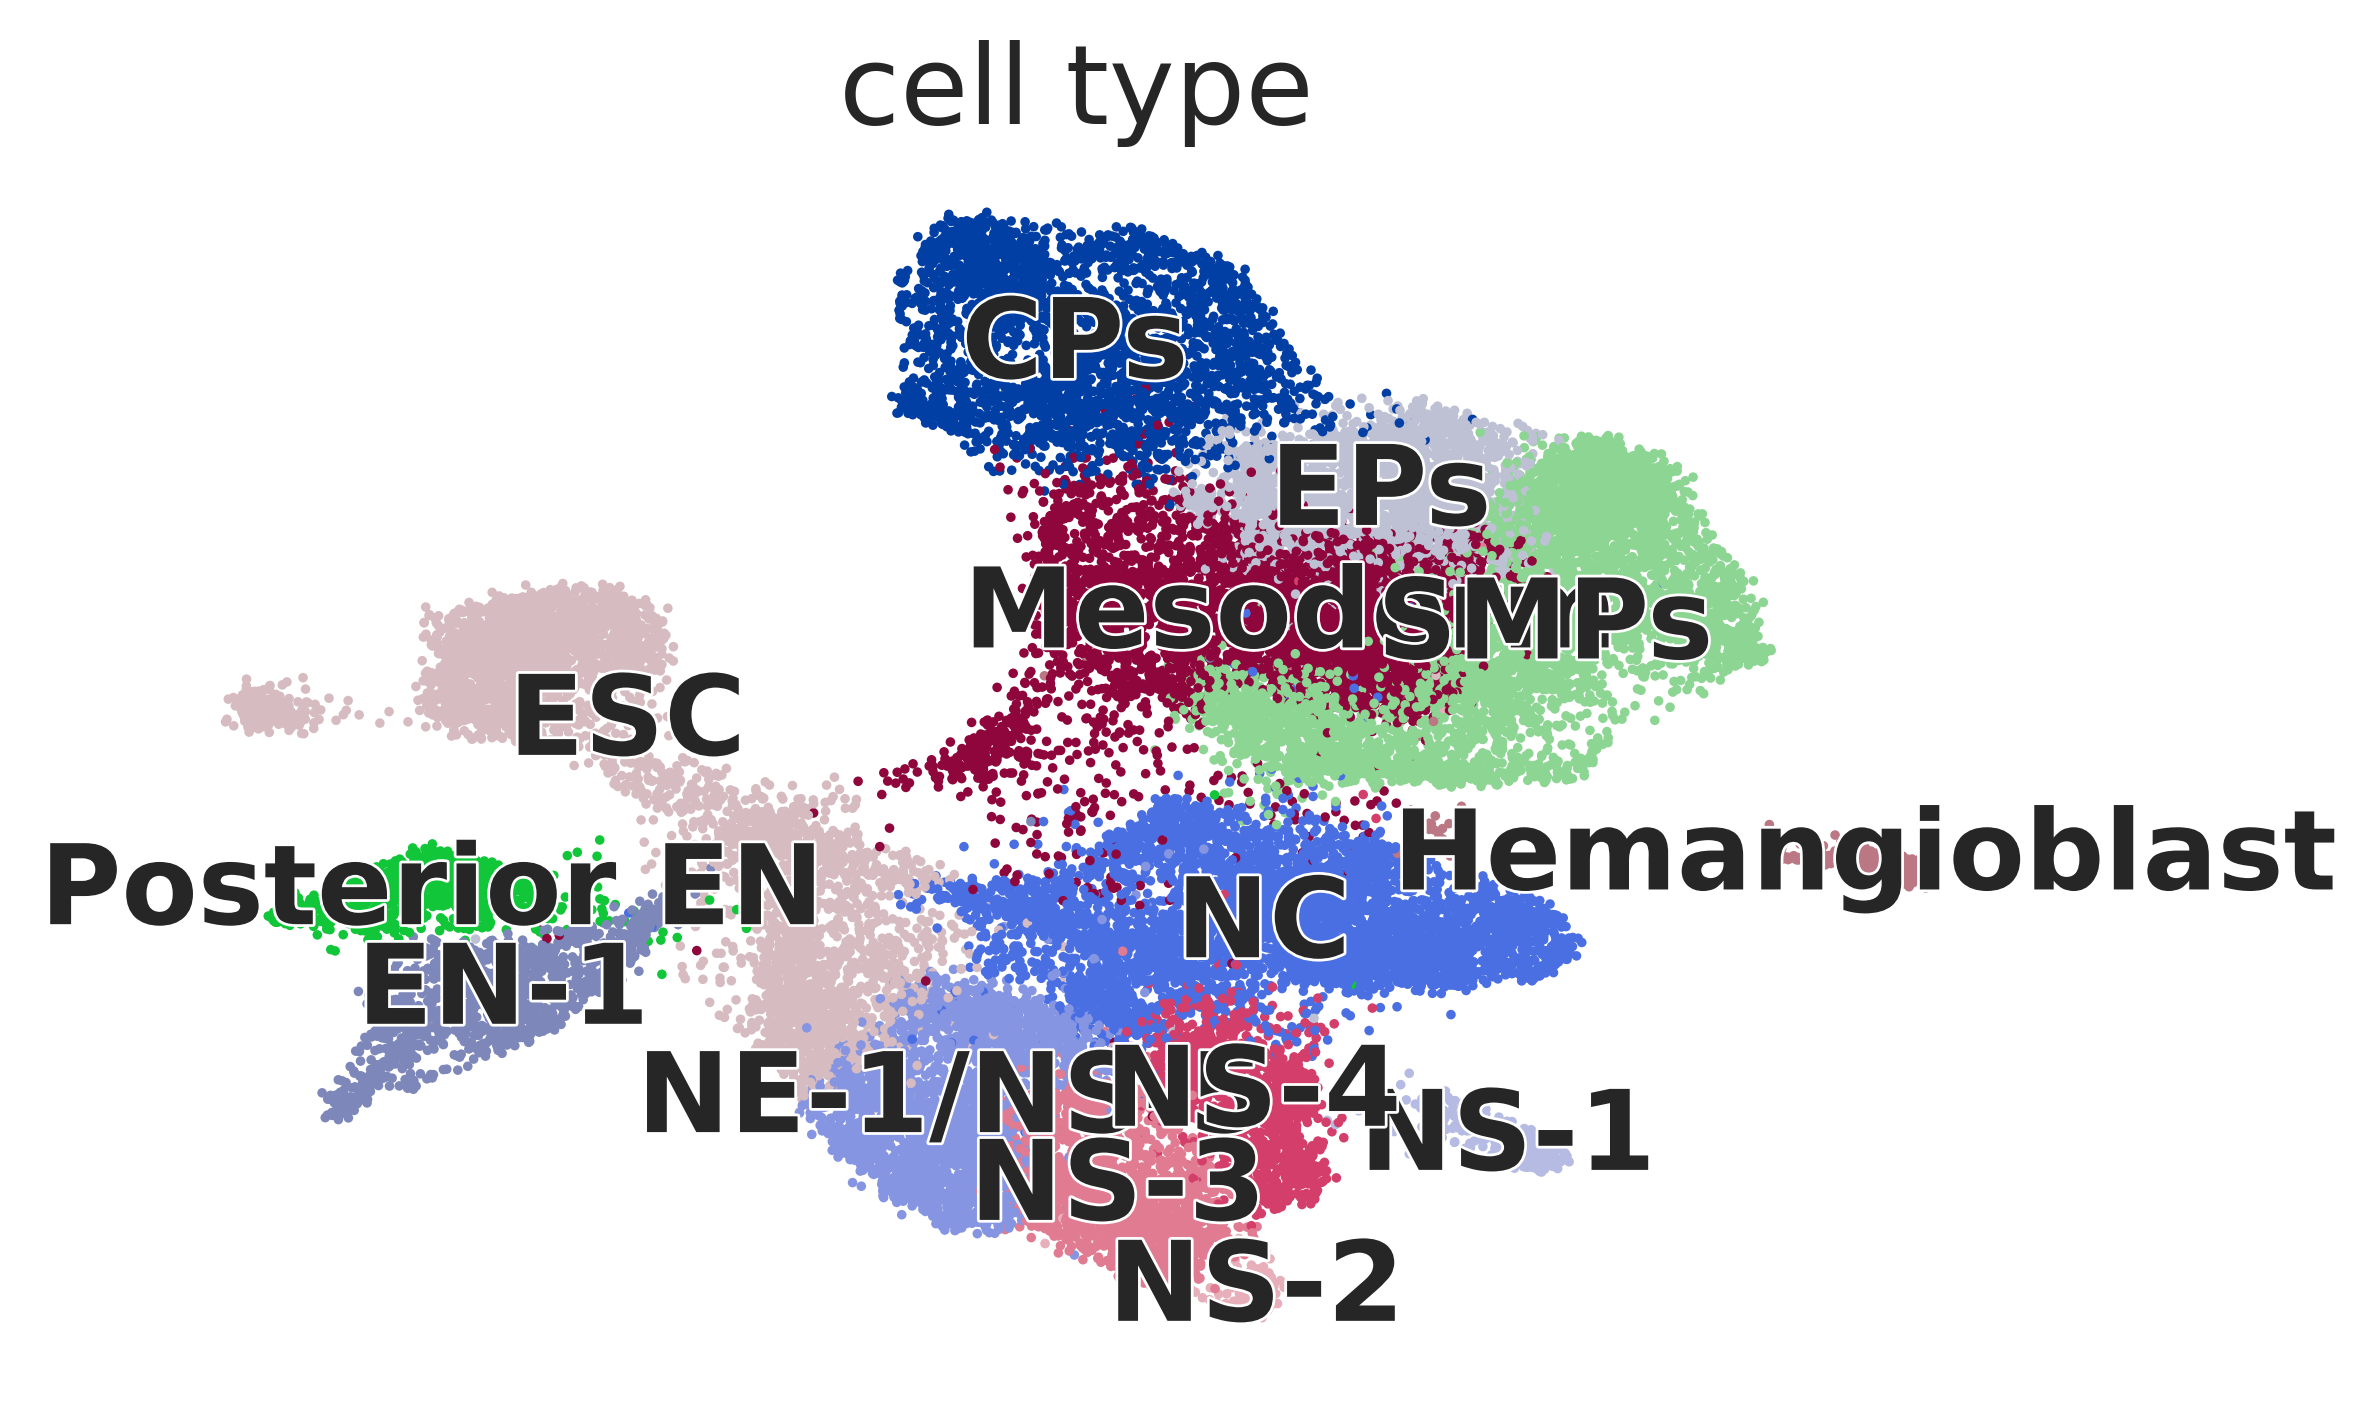

In [8]:
scv.pl.scatter(adata, basis="umap", c="cell_type", dpi=200)

## Pseudotime construction

In [9]:
pc_projection = pd.DataFrame(adata.obsm["X_pca"].copy(), index=adata.obs_names)

In [10]:
diff_maps = palantir.utils.run_diffusion_maps(pc_projection, n_components=5)

Determing nearest neighbor graph...
computing neighbors
    finished (0:02:35)


In [11]:
multiscale_space = palantir.utils.determine_multiscale_space(diff_maps)

In [12]:
magic_imputed = palantir.utils.run_magic_imputation(adata, diff_maps)

In [13]:
# See DPT notebook for root cell identification
root_idx = 1458
palantir_res = palantir.core.run_palantir(
    multiscale_space, adata.obs_names[root_idx], use_early_cell_as_start=True, num_waypoints=500
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.08258782227834066 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...


findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling bac

Time for shortest paths: 0.5515306274096171 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [14]:
adata.obs["palantir_pseudotime"] = palantir_res.pseudotime

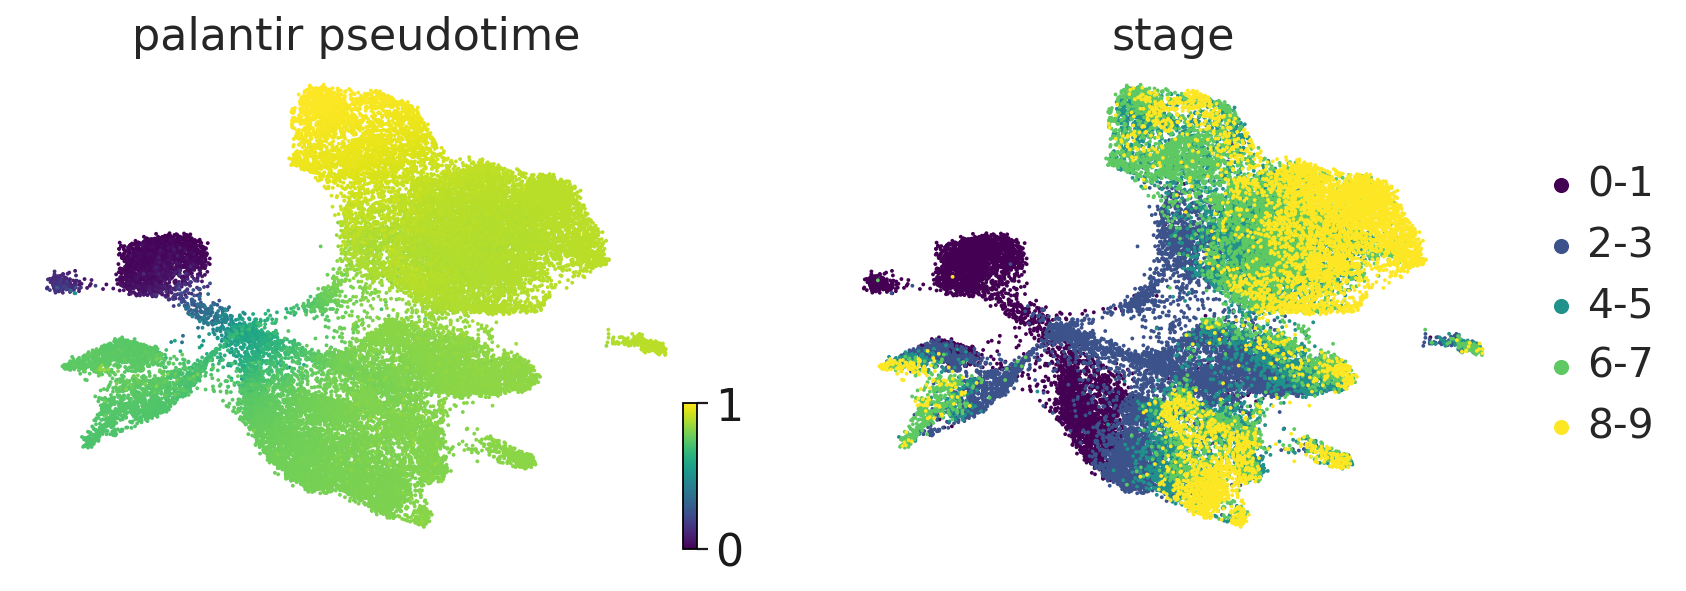

In [15]:
scv.pl.scatter(
    adata,
    c=["palantir_pseudotime", "stage"],
    basis="umap",
    legend_loc="right",
    color_map="viridis",
)

if SAVE_FIGURES:
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(
        adata, basis="umap", c="palantir_pseudotime", title="", legend_loc=False, colorbar=False, cmap="gnuplot2", ax=ax
    )

    fig.savefig(
        FIG_DIR / "cytotrace_kernel" / "embryoid_body" / "umap_colored_by_palantir_pseudotime.eps",
        format="eps",
        transparent=True,
        bbox_inches="tight",
    )

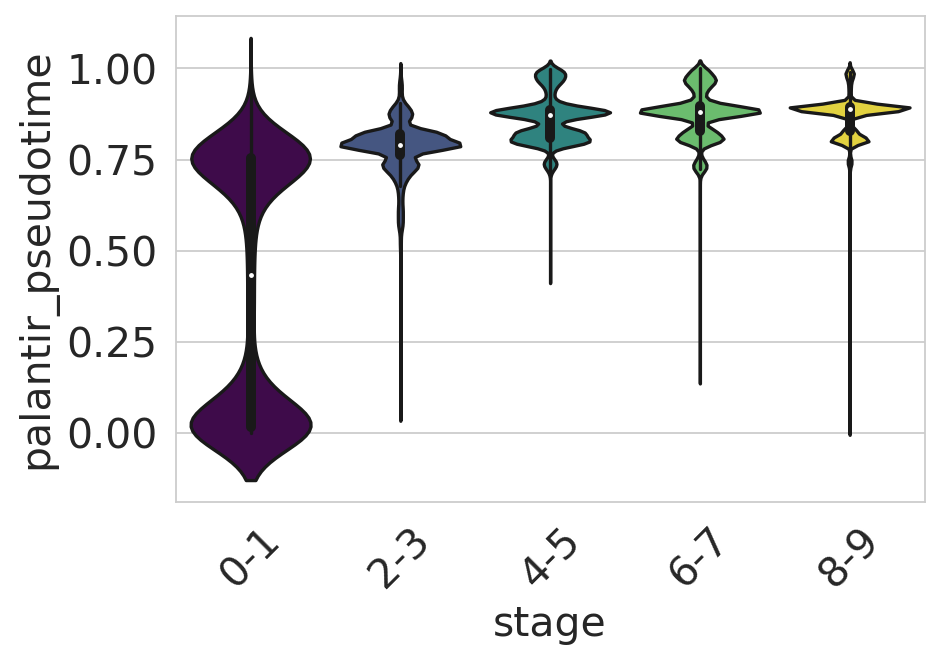

In [16]:
df = adata.obs[["palantir_pseudotime", "stage"]].copy()

sns.set_style(style="whitegrid")
fig, ax = plt.subplots(figsize=(6, 4))
sns.violinplot(
    data=df,
    x="stage",
    y="palantir_pseudotime",
    scale="width",
    palette=["#440154", "#3b528b", "#21918c", "#5ec962", "#fde725"],
    ax=ax,
)

ax.tick_params(axis="x", rotation=45)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
plt.show()

if SAVE_FIGURES:
    ax.set(xlabel=None, xticklabels=[], ylabel=None, yticklabels=[])

    fig.savefig(
        FIG_DIR / "cytotrace_kernel" / "embryoid_body" / "palantir_vs_stage.eps",
        format="eps",
        transparent=True,
        bbox_inches="tight",
    )
sns.reset_orig()